In [26]:
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error,mean_squared_error 
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

import pandas as pd

# import matplotlib.pyplot as plt
# import pandas as pd
# from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

From ML with R
"The goal of evaluating a classification model is to have a better understanding of how its performance with extrapolate to future cases. SInce it is usually not feasible to test a still unprove model in a live, environment, we typically simulate fugure conditions by asking the model to classify a dataset made of cases that resimble what it woll be asked to do in the future. By observing the learner's responses to this examination, we can learn abou tits strenghts ans weaknesses"

We accomplish this by comparing the model's predicted class values to the actual class values 

This tutorial draws code and content from Kevin Markham's General Assembly data science course https://github.com/justmarkham/DAT8, maykulkarni's machine learning notebooks repo [https://github.com/maykulkarni] 

Content is also drawn from An Introduction to Statistical Learning, Applied Predictive Modeling, and Machine Learning with R


# Part I: Metrics

### Classification Metrics
**Accuracy** is the number of correct predictions divided by the total number of predictions made

<br/><br/>

$$\text{Accuracy} = \frac{\text{# Correct Predictions}}{\text{Total # of Predictions}}$$

<br/><br/>

Imagine that we are trying to build a model to filter out spam email. The following data contains the text of email messages along with their actual type (i.e., label). "Ham" messages constitute real email messages whereas "spam" messages are, well, spam.  

In [ ]:
#Data from https://github.com/PacktPublishing/Machine-Learning-with-R-Third-Edition
spam_ham = pd.read_csv('sms_spam.csv')
spam_ham = spam_ham[['type']]
spam_ham.head()

If we have a quick look at the type column, we can see that most messages are ham.

In [ ]:
counts_df = spam_ham [['type']].groupby(['type']).size().reset_index(name='outcome_counts')

counts_df['percentage'] = counts_df['outcome_counts'] / counts_df['outcome_counts'].sum()

counts_df

In [ ]:
t= np.zeros(spam_ham.size)
t.size

Using this data, we can build a very simple classifier, which just predicts the majority class. In other words, the classifier will always predict "ham."  

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
#dummy_clf = DummyClassifier(strategy="stratified")
#Note, by definition, the features are ignored in this model
dummy_clf.fit(np.zeros(spam_ham.size), spam_ham[['type']])
#dummy_clf.fit(spam_ham[['text']], spam_ham[['type']])
dummy_predictions = dummy_clf.predict(np.zeros(spam_ham.size))

accuracy = round(accuracy_score(spam_ham[['type']], dummy_predictions),2)
print(f'Accuracy of majority class model is: {accuracy}')

Judging by overall accuracy alone, we might conclude that the dummy classifier is doing a decent job. But of course, this is is not a good model since it never predicts "spam," which is what we are actually trying to get the model to do correctly.

A **confusion matrix** is used for classification models. It allows us to break down our results in terms of true positives, true negatives, false positives, and false negatives. This gives us a better sense of the kinds of errors our model is making
<br/><br/>

|            | Predicted true | Predicted false |
|------------|----------------|-----------------|
|Actual true | True Positive  | False Negative  |
|Actual false| False Positive | True Negative   |

<br/><br/>

Accordingly, we can reframe our formula for accuracy as

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
<br/><br/>

We can create a confusion matrix from our majority class model

In [ ]:
cm = confusion_matrix(spam_ham[['type']], dummy_predictions)

#need to flip so spam is the positive case
cm = np.flip(cm)


cm_df = pd.DataFrame(cm, 
               columns=['predicted_spam', 'predicted_ham'], 
               index = ['actual_spam', 'actual_ham'])



cm_df

In this case, we'll consider "spam" the positive case since that is what we are trying to detect. So, cases where the model predicted "ham" but the message was actually "spam" are false negatives. We have 747 of these cases.

Because the dummy classifier always predicts "ham," there are no cases where the model predicted "spam" and the actual outcome was "ham;" however, if it had, those would constitute false positives.

Even though our model performed well in terms of overall accuracy, we can see from the confusion matrix that it performed abysmally in terms of false negatives. In machine learning, overall accuracy provides a poor measure of a model's performance when we have a "class imbalance," meaning one label occurs much more frequently than the other(s). 



Often with machine learning, we neither want a model that is too conservative in predicting the positive class nor too aggressive. Two metrics that help us assess this are precision and recall

<br/><br/>
**Precision** captures what proportion of the model's prediction of the positive class actually belong to the positive class 

$$\text{Precision} = \frac{TP}{TP + FP}$$

<br/><br/>

**Recall** captures the proportion of cases that actually belong to the positive class were predicted as positive by the model. 

$$\text{Recall} = \frac{TP}{TP + FN}$$


<br/><br/>
A precise model will only predict the positive class when the example is very likely to be positive. A model that has high recall will capture a large proportion of the actual positive examples. 

We will calculate precision and recall for our dummy classifier, but first we need to do some minor modifications on our predictions to make this possible. If we attempt to calculate these metrics from just the majority class predictions, we'll get into some divide by zero issues for precision since we have no spam predictions. 

I'll demonstrate this below, just to show you. 

In [ ]:
TP = cm_df.loc['actual_spam', 'predicted_spam']
TN = cm_df.loc['actual_ham', 'predicted_ham']
FP = cm_df.loc['actual_ham', 'predicted_spam']
FN = cm_df.loc['actual_spam', 'predicted_ham']

print (f'Precision is {TP/(TP + FP)}')
print (f'Recall is {TP/(TP + FN)}')

Okay. For illustrative purposes, we'll add a few additional observations to our dataset that will allow us to calculate these metrics.

In [ ]:
new_data = pd.DataFrame(['spam', 'spam', 'spam', 'spam', 
                         'spam', 'spam', 'ham', 'ham'], columns=['type'])


new_predictions = np.array(['spam', 'spam', 'spam', 'spam', 
                                'spam', 'spam', 'spam', 'spam'])

new_spam_ham = pd.concat([spam_ham, new_data], ignore_index=True)
new_dummy_predictions = np.append(dummy_predictions, new_predictions)

new_cm = confusion_matrix(new_spam_ham[['type']], new_dummy_predictions)

#need to flip so spam is the positive case
new_cm = np.flip(new_cm)


new_cm_df = pd.DataFrame(new_cm, 
               columns=['predicted_spam', 'predicted_ham'], 
               index = ['actual_spam', 'actual_ham'])



new_cm_df


Our new confusion matrix reveals that we have 6 true positives, 4812 true negatives, 2 false positives, and 747 false negatives. With these, we can now calculate precision and recall.

In [ ]:
TP = new_cm_df.loc['actual_spam', 'predicted_spam']
TN = new_cm_df.loc['actual_ham', 'predicted_ham']
FP = new_cm_df.loc['actual_ham', 'predicted_spam']
FN = new_cm_df.loc['actual_spam', 'predicted_ham']

dc_precision = TP/(TP + FP)
dc_recall = TP/(TP + FN)

print (f'Precision is {dc_precision}')
print (f'Recall is {dc_recall}')


Precision is better than recall. Why is this? We have designed our dummy classifier so that it almost never predicts "spam." The data we added contained only 8 predictions of "spam," 6 of which were correct (6/8 = 0.75). So, when our dummy model does predict the positive class (i.e., "spam"), it does a pretty decent job. It's a reasonably precise model.

What our model does not do well is cover all the actual instances of spam in the dataset. This is captured in our recall measure, which is very low. Again, this is because our model is not capable of capturing (i.e., correctly predicting) most of the actual spam examples.

Precision and recall can tell us a lot about how our model is performing, but it's nice to have a single summary statistic as well. The F1 Score or F-measure, which combines precision and recall using the harmonic mean.

**F1 score** is the harmonic mean of precision and recall. 


$$\text{F}_1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$

In [ ]:
dc_F1 = 2* ((dc_precision*dc_recall)/(dc_precision + dc_recall))
print(f'F1 is: {dc_F1}')

Note, we can also calculate all these metrics using the metrics functionality of scikit learn. We just need to convert our classes to binary first.

In [ ]:
new_spam_ham['pos_case'] = np.where(new_spam_ham['type']== 'spam', 1, 0)
new_dummy_predictions_binary = np.where(new_dummy_predictions == "spam", 1,0)
f1_score(new_spam_ham[['pos_case']], new_dummy_predictions_binary)


There are many other metrics for evaluating classification models. Techniques that may be a particular help for visualizing results are precision recall curves or receiver operating characteristic (ROC) curves. You can learn more about these techniques here [INSERT LINK]

### Regression Metrics

So far we have only discussed metrics for evaluating classification models, but of course, there are metrics for evaluating regression models as well. Several metrics that are commonly used include mean absolute error, mean squared error, and root mean squared error. In the formulas below, $y_i$ is the actual value for observation i and $\hat{y}_i$ is the predicted value for observation i

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$
 
**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$





Introduce LASSO? Do the overfitting bit and then move on to regression metrics? Need to include some kind of model data here to build things out. Possibly use the same basketball data?

In [ ]:
# # import numpy as np
# print ('MAE:', metrics.mean_absolute_error(true, pred))
# print ('MSE:', metrics.mean_squared_error(true, pred))
# print ('RMSE:', np.sqrt(metrics.mean_squared_error(true, pred)))

#steal some stuff from this: https://github.com/justmarkham/DAT8/blob/master/other/model_evaluation_comparison.md

## Evaluation Paradigms

<font size="1"> *Source note: This next section of the workshop notebook is takes sections, some nearly verbatim, from [this notebook](https://github.com/justmarkham/DAT8/blob/master/notebooks/09_model_evaluation.ipynb) because it contains one of the best explainations of evaluation paradigms I've come across.* </font>

Thus far, we have discussed evaluation without diving into which data metrics are calculated on. In machine learning, we train a model on one dataset with the goal of making accurate predictions in another dataset. In other words, we aim to create a model that has good generalization. Our evaluation metrics should ideally give us a good sense of how well our model would perform on new data. We will explore several different strategies for training and evaluating models that have different implications for generalization (some good and some not so good).

First, let's load some new data.

From the blog post: "Now we’re ready to prepare our training data. To do this, we’ll take the per-season, average stats. We’ll sum this and then divide by seasons played. This will give us per-game averages. We use per-game averages because it factors career-length into the model. In other words, if a player scored 2,000 career assists, it matters whether that player accomplished it within seven years or 15 years in the league, as it will show how efficient they were in their respective position.

So for example, if a player averaged 15 points per game in their first season, and 20 points per game in their second season, we’ll sum 15 and 20 to get 35, then divide by 2 seasons played to get a career average points-per-game of 17.5."

AST - Assists





Going to attempt to adapt what Brian has already done for continuity. Either attempt to use the same regression example or predict whether red or white?

In [ ]:
# download wine datasets, load directly into a Pandas DataFrame
url_red = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
url_white = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
# these data are in text tables in which the separation of columns is indicated with a semicolon ";" 
red_df = pd.read_csv(url_red, sep=";")
white_df = pd.read_csv(url_white, sep=";")

In [2]:
nba = pd.DataFrame(columns = ['ast','stl','blk','tov','pf','pts', 
                                             'name', 'position', 'team'])

In [3]:
import glob, os
csv_files = []
os.chdir("/Users/amywinecoff/Documents/CITP/Research/Github/ml-teaching/basketball_reference_scraper/data/players")
for file in glob.glob("*.csv"):
    csv_files.append(file)

for csv in csv_files:
    d = pd.read_csv(csv)
    nba = pd.concat([nba, d], axis=0)

In [4]:
nba.head()

,ast,stl,blk,tov,pf,pts,name,position,team
0,1.071429,0.414286,0.128571,0.500000,1.171429,5.057143,Rodney McGruder,SG,DET
0,1.525000,0.625000,0.325000,1.375000,2.850000,13.925000,De'Andre Hunter,SF,ATL
0,1.228571,0.528571,0.142857,0.685714,1.385714,5.871429,Troy Brown Jr.,SF,CHI
0,4.866667,1.100000,0.433333,2.200000,2.666667,7.266667,Killian Hayes,PG,DET
0,1.357143,0.814286,0.400000,0.900000,2.100000,8.057143,Dorian Finney-Smith,PF,DAL


In [5]:
# map positions to numbers
nba['pos_num'] = nba.position.map({'C':0, 'SF':1, 'PF':1, 'SG':2, 'PG':2})

In [ ]:
nba.columns

In [51]:
X = nba[['ast', 'stl', 'blk', 'tov', 'pf', 'pts']]

# create response vector (y)
y = nba.pos_num


In [54]:
from sklearn.preprocessing import StandardScaler
#https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

scaler = StandardScaler()
# # Fit only on X_train
# scaler.fit(X_train)

# # Scale both X_train and X_test
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

scaler.fit(X)

# # Scale both X_train and X_test
X_scale = scaler.transform(X)
# X_test = scaler.transform(X_test)

In [56]:
X_scale.shape

(132, 6)

### Train on all the data

One method for fitting and evaluating models would be to develop a model that is maximally accurate on our entire dataset and report the accuracy of that model as calculated over the entire dataset. However, this strategy will likely lead to an overly complex model that captures the training data well, but generalizes poorly to new data. For this reason, it is not recommended to train and evaluate models on the same dataset.

In [57]:
# import the class
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model
knn = KNeighborsClassifier(n_neighbors=10)

# train the model on the entire dataset
knn.fit(X_scale, y)

# predict the response values for the observations in X ("test the model")
knn.predict(X_scale)

array([2, 1, 2, 2, 1, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 2, 2, 1, 1, 1, 2,
       0, 2, 2, 0, 1, 0, 1, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 2, 1, 1, 2, 0, 2, 1, 0,
       1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 1, 0, 1, 1, 2, 1, 2, 1, 2, 2, 0,
       1, 2, 0, 1, 1, 2, 1, 2, 0, 2, 2, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1,
       2, 0, 0, 2, 1, 1, 2, 2, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2])

In [58]:
# store the predicted response values
y_pred_class = knn.predict(X_scale)

In [59]:
print (accuracy_score(y, y_pred_class))

0.7348484848484849


This is known as training accuracy because we are evaluating the model on the same data we used to train the model.



KNN(k=1)

In [39]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_scale, y)
y_pred_class = knn.predict(X_scale)
print (accuracy_score(y, y_pred_class))
#See also https://medium.com/analytics-vidhya/prediction-and-data-visualization-of-breast-cancer-using-k-nearest-neighbor-knn-classifier-df7adadc4872

1.0


Text(0.5, 1.0, 'KNN Decision Region Boundary, k=10')

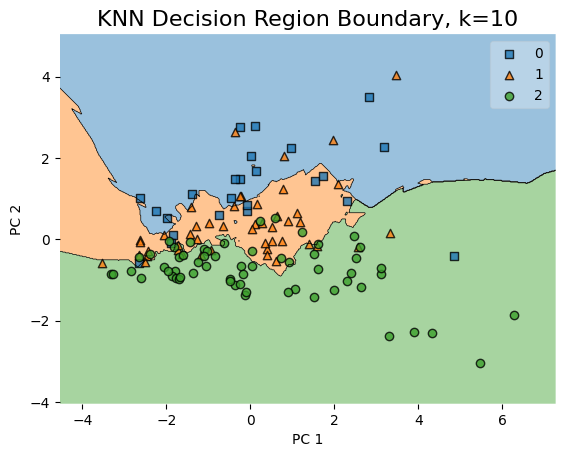

In [66]:
# Plotting decision regions
#plot_decision_regions(X[['ast', 'stl']].values, y.values, clf=knn, legend=2)
# plot_decision_regions(X.values, y.values, clf=knn, legend=2)

# # Adding axes annotations
# plt.xlabel('sepal length [cm]')
# plt.ylabel('petal length [cm]')
# plt.title('SVM on Iris')
# plt.show()


#from mlxtend.plotting import plot_decision_regions
neighbors = 10
#clf = SVC(C=100,gamma=0.0001)
pca = PCA(n_components = 2)
X2 = pca.fit_transform(X_scale)

# X2 = X_scale[:, 4:6]
knn = KNeighborsClassifier(n_neighbors=neighbors)
knn.fit(X2, y)
plot_decision_regions(X2, y.values, clf=knn, legend=1)

# plt.xlabel(X.columns[0], size=14)
# plt.ylabel(X.columns[1], size=14)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title(f'KNN Decision Region Boundary, k={neighbors}', size=16)

In [ ]:
X

### Train/Test Splits
One alternative approach is to partition your dataset into two subsets. You train your model on one subset (ie., the training set) and evaluate your model in the other (i.e., the test set). The model's performance on the test set is referred to as the **testing accuracy** because we are evaluating the model on an (in theory) independent dataset that was not used during model training. For this reason, testing accuracy is usually a better estimate of out-of-sample performance than training accuracy.

We can use the built-in functionality in scikit learn to split our data into training and testing sets. For this section of the workshop, we will work with a new dataset. 

In [ ]:
#https://github.com/justmarkham/DAT8/blob/master/notebooks/20_regularization.ipynb
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'
crime = pd.read_csv(url, header=None, na_values=['?'])



crime.head()


In [ ]:
crime.drop([0, 1, 2, 3, 4], axis=1, inplace=True)
crime.dropna(inplace=True)

# define X and y
X = crime.drop(127, axis=1)
y = crime[127]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

X, y = make_classification()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
clf = SVC().fit(X_train, y_train)
confusion_matrix(y_test, clf.predict(X_test))

|            | predicted true | predicted false |
|------------|----------------|-----------------|
|actual true |        10      |        0        |
|actual false|         1      |        9        |